# Forecasting cab orders
Taxi service has collected historical data on cab orders at an airport. In order to attract more drivers during peak periods, it is necessary to predict the number of cab orders for the next hour.
It is necessary to build a model for this prediction.

The value of the *RMSE* metric on the test sample should be at most 48.

Working plan:

1. Load the data and re-sample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of size 10% of the original data.
4. Validate the data on the test sample and draw conclusions.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-to-know-the-data" data-toc-modified-id="Getting-to-know-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting to know the data</a></span><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Dickey-Fuller-stationarity" data-toc-modified-id="Dickey-Fuller-stationarity-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Dickey-Fuller stationarity</a></span></li><li><span><a href="#New-parameters-and-sampling-split" data-toc-modified-id="New-parameters-and-sampling-split-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>New parameters and sampling split</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Model-training-and-testing" data-toc-modified-id="Model-training-and-testing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model training and testing</a></span><ul class="toc-item"><li><span><a href="#Preparations-for-training" data-toc-modified-id="Preparations-for-training-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preparations for training</a></span></li><li><span><a href="#Dummy-models" data-toc-modified-id="Dummy-models-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Dummy models</a></span></li><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#Decision-tree" data-toc-modified-id="Decision-tree-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Decision tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Model-Comparison" data-toc-modified-id="Model-Comparison-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Model Comparison</a></span></li><li><span><a href="#Verification-on-a-test-sample" data-toc-modified-id="Verification-on-a-test-sample-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Verification on a test sample</a></span></li><li><span><a href="#Checking-the-influence-of-parameters" data-toc-modified-id="Checking-the-influence-of-parameters-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Checking the influence of parameters</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import time

## Getting to know the data
### Preparation
Let's load the data and familiarize ourselves with it.

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('C:/Users/Ivan/datasetsYP/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)

print(df.columns)
display(df.sample(10))
display(df.describe())
display(df.info())
display(df.isnull().sum())

Index(['num_orders'], dtype='object')


,num_orders
datetime,
2018-04-10 16:40:00,7
2018-07-20 20:00:00,23
2018-07-10 23:20:00,12
2018-08-27 16:10:00,33
2018-06-13 16:40:00,17
2018-03-17 22:10:00,13
2018-05-25 11:00:00,15
2018-03-02 15:20:00,5
2018-08-02 07:30:00,9


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

num_orders    0
dtype: int64

In [3]:
print(df.index.min(), df.index.max())
print('Is the indices series monotonic?', df.index.is_monotonic)

2018-03-01 00:00:00 2018-08-31 23:50:00
Is the indices series monotonic? True


count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

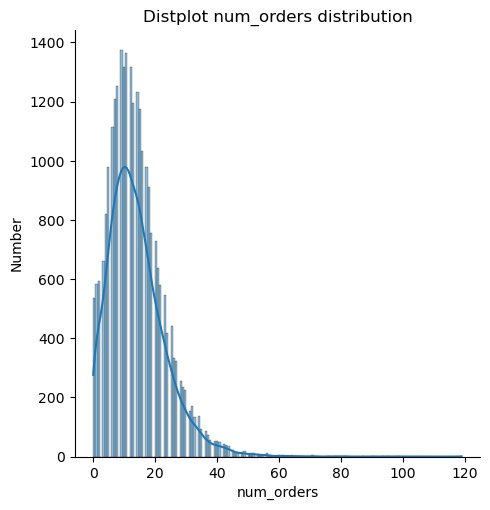

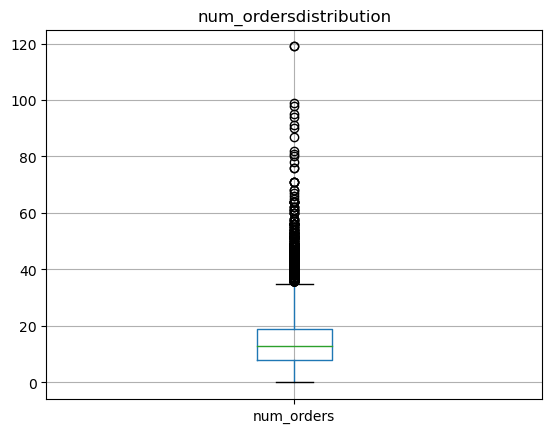

In [4]:
def analysis_of_quntitative_parametr(df, name):
    display(df[name].describe())
    
    sns.displot(df[name], kde=True)
    plt.title(label=f'Distplot {name} distribution', loc='center')
    plt.xlabel(f"{name}")
    plt.ylabel("Number")
    plt.show()

    df.boxplot(column=name)
    plt.title(label=f'{name}distribution', loc='center')
    plt.show()
    
    return

analysis_of_quntitative_parametr(df, 'num_orders')

The dataset is limited - in fact, it is one column with the number of orders at different times. No obvious outliers are detected, perhaps something will be more noticeable with hourly sampling. There are no repeats in time.
The data is presented for 6 months of 2018 (from March to August inclusive).

### Analysis
Let's re-sample the data, and take another look at how the data looks at one hour intervals.
See if there are trends, patterns, etc.

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

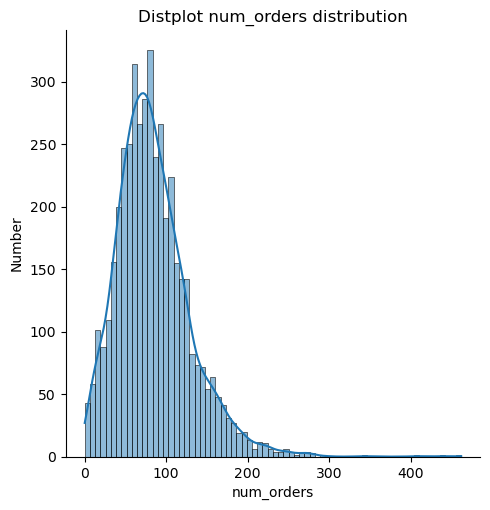

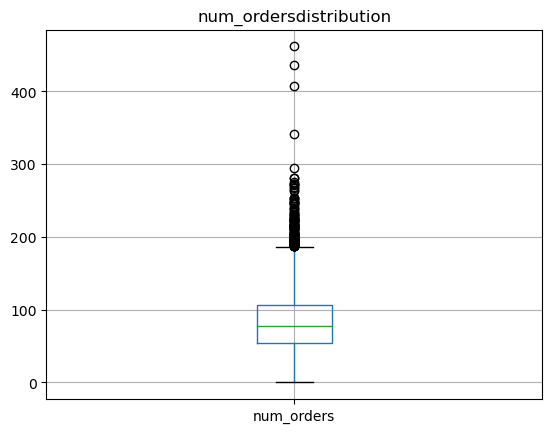

In [5]:
df_1H = df.resample('1H').sum()
df_1D = df.resample('1D').sum()
df_1W = df.resample('1W').sum()

analysis_of_quntitative_parametr(df_1H, 'num_orders')

The distribution over hours looks smooth, similar to a lognormal distribution. There are no obvious outliers.

Analysis for whole period hourly


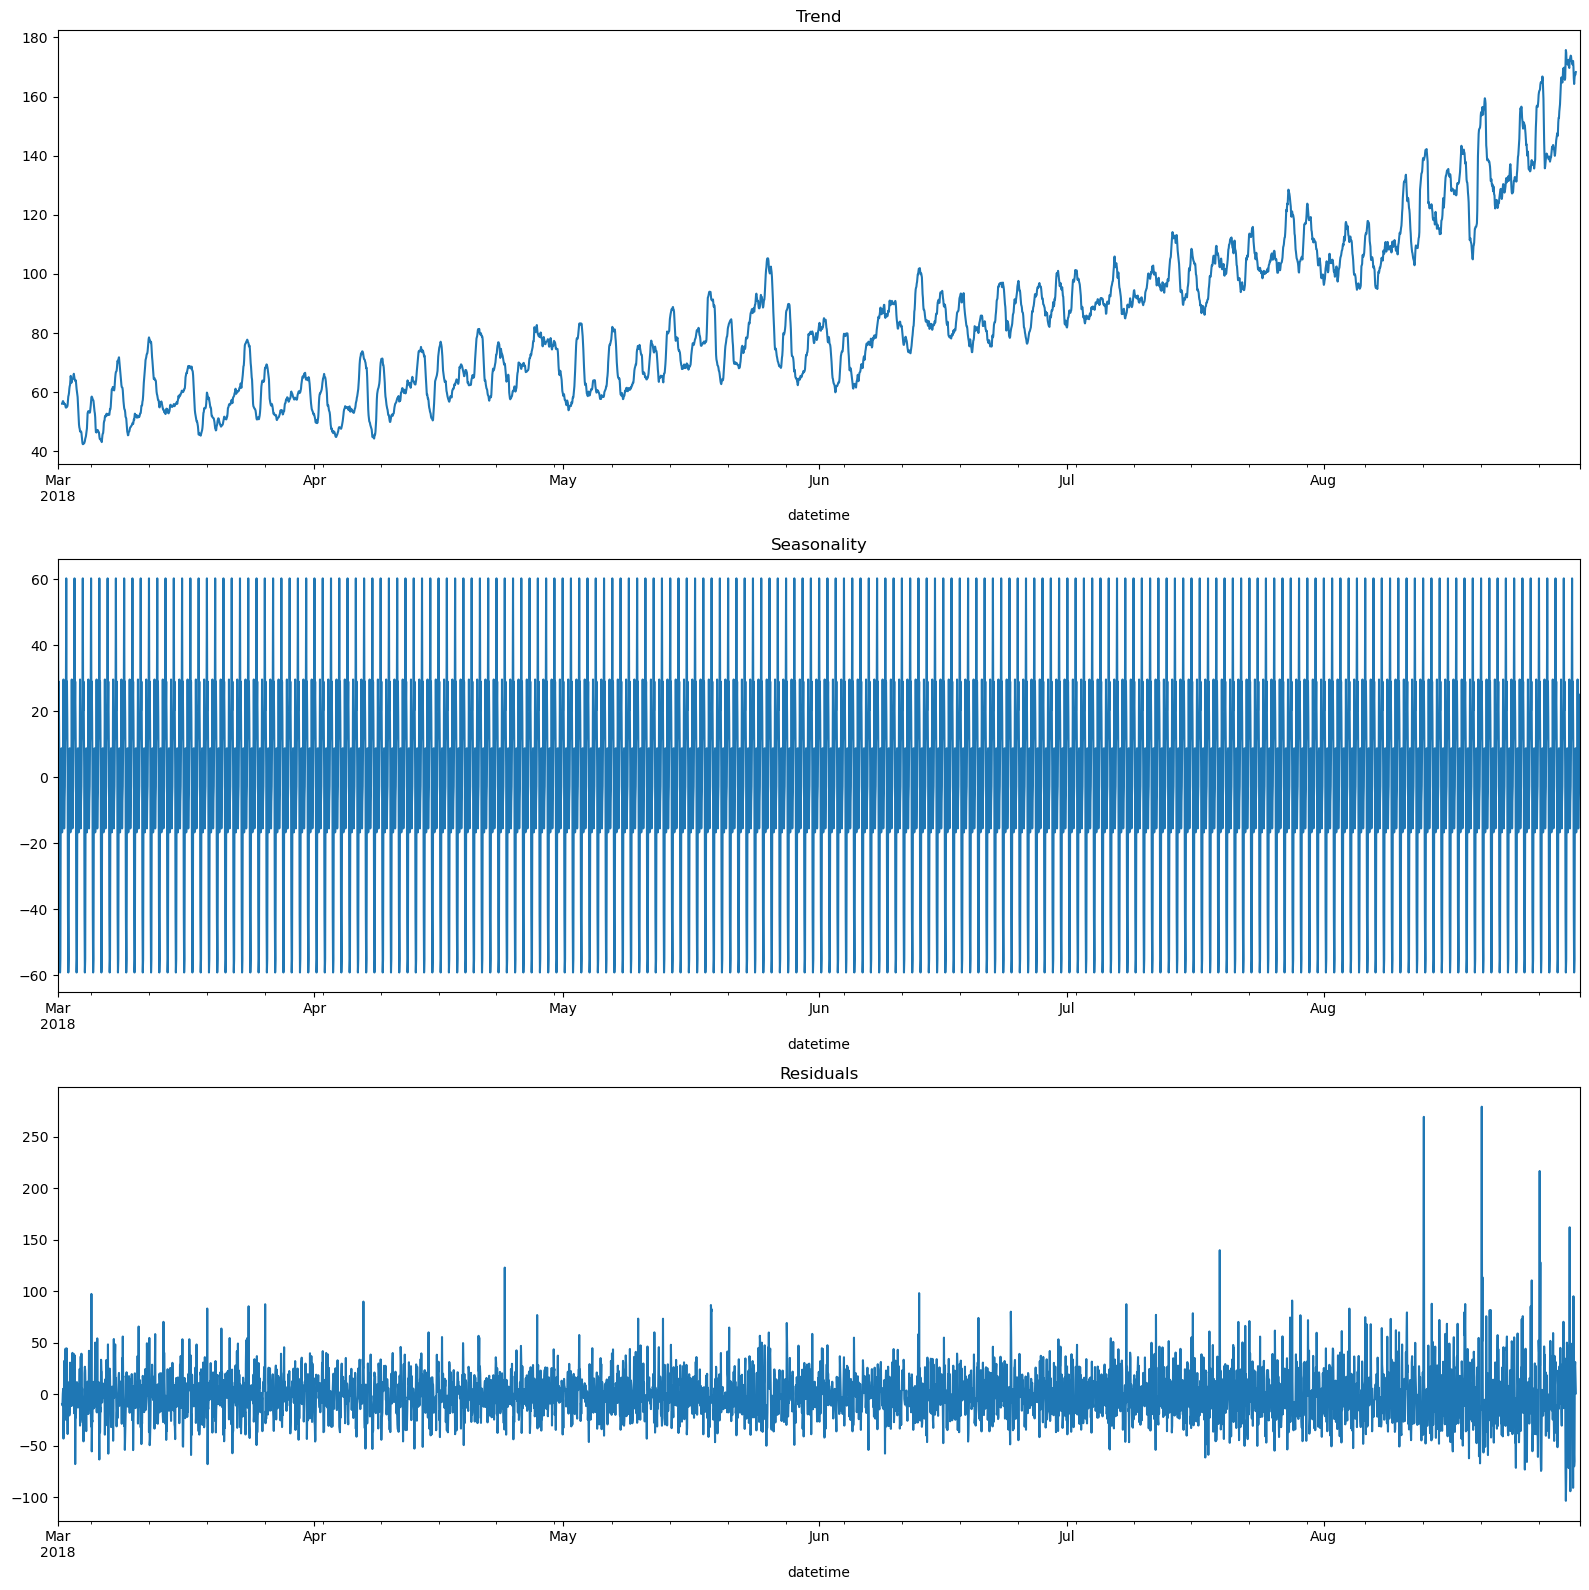

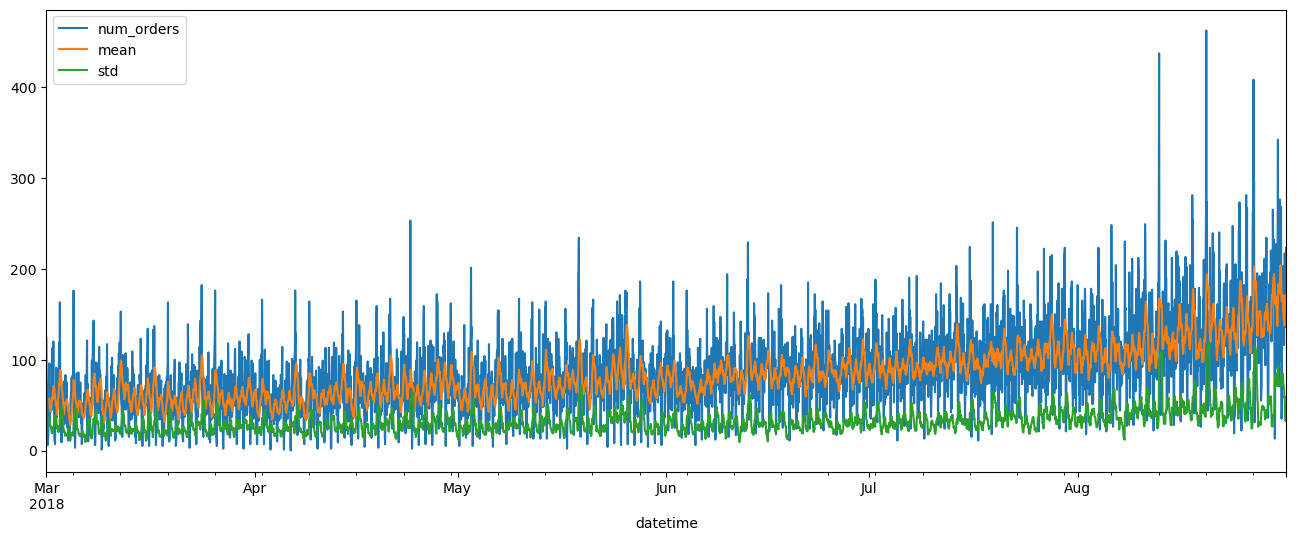

Analysis for whole period daily


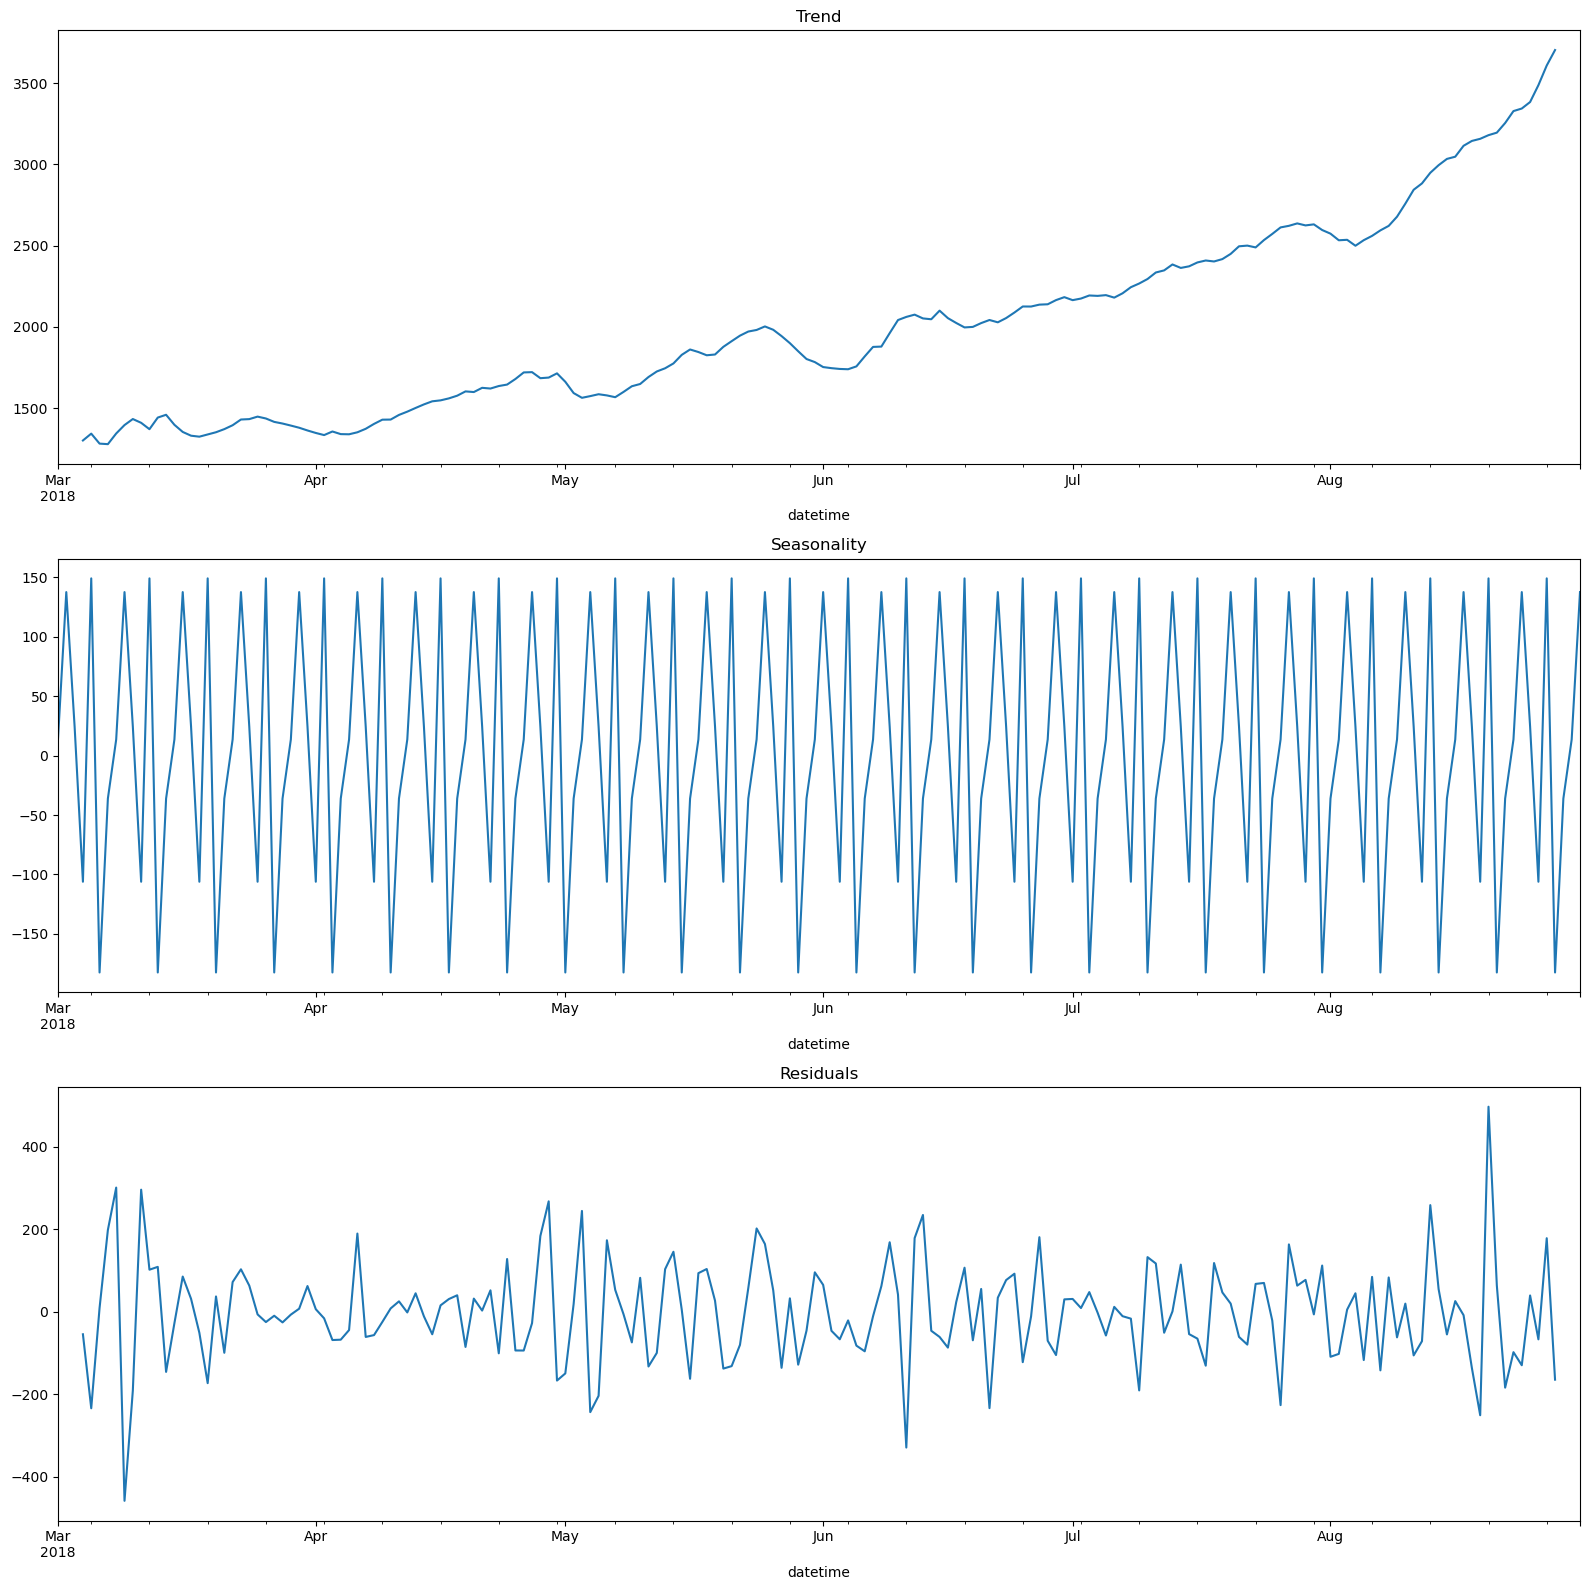

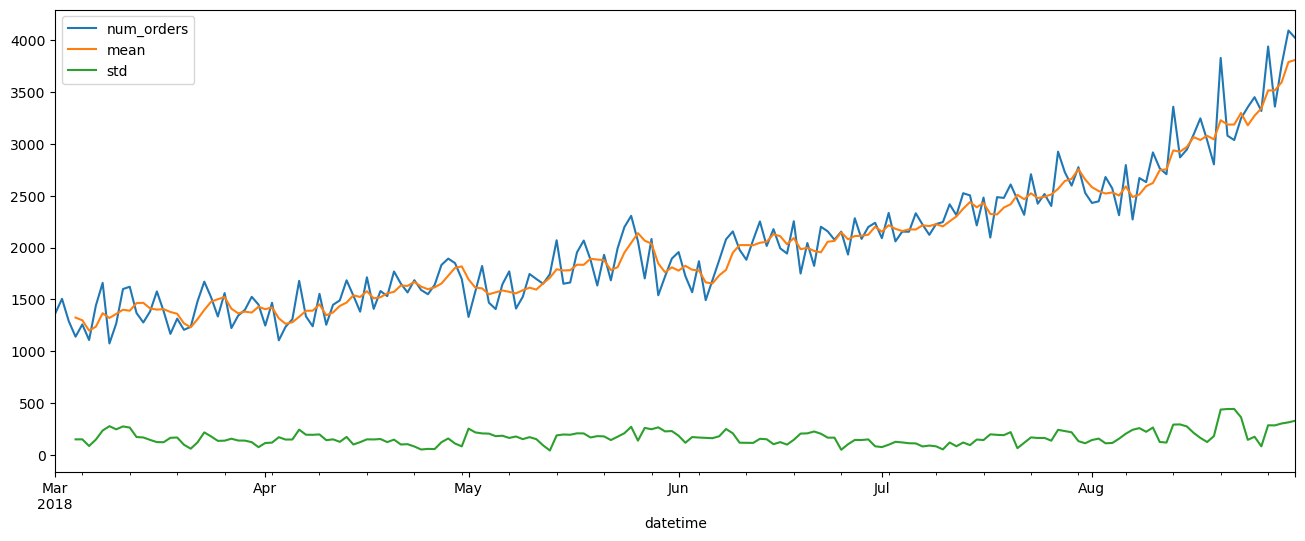

Analysis for whole period weekly


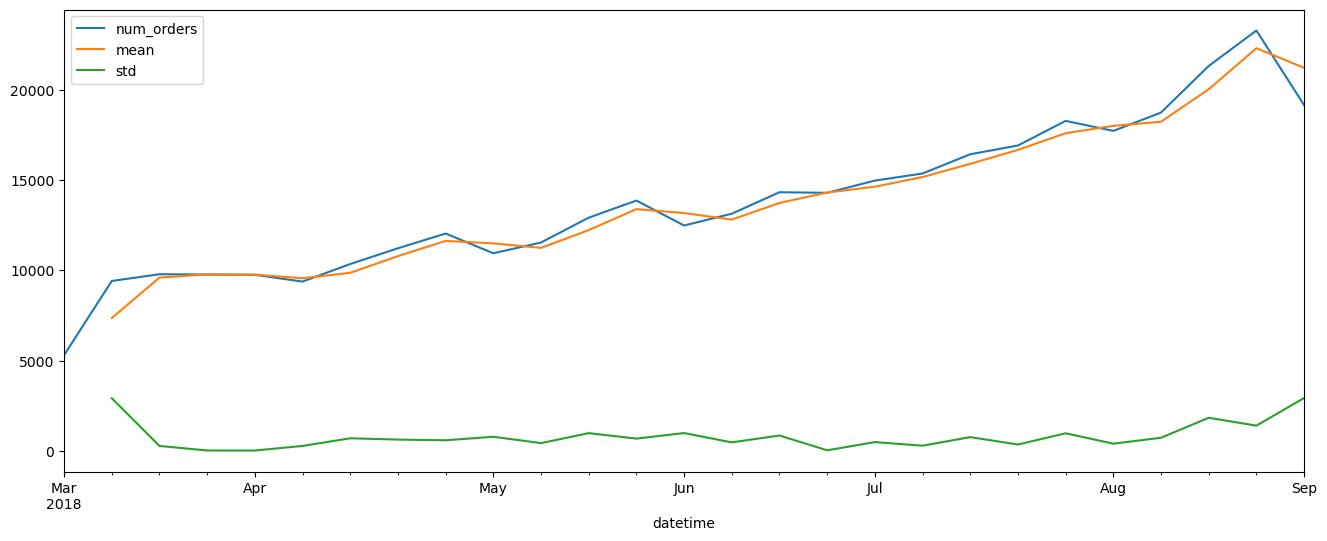

In [6]:
def decompose_and_show_info(dataframe, name, start, end, rolling_value):
    print(f'Analysis for {name}')
    df = dataframe[start:end]
    
    if (name != 'whole period weekly'):
        decomposed = seasonal_decompose(df)

        plt.figure(figsize=(16, 16))
    
        plt.subplot(311)
        decomposed.trend.plot(ax=plt.gca())
        plt.title('Trend')

        plt.subplot(312)
        decomposed.seasonal.plot(ax=plt.gca())
        plt.title('Seasonality')

        plt.subplot(313)
        decomposed.resid.plot(ax=plt.gca()) 
        plt.title('Residuals')
        
        plt.tight_layout()
        
        plt.show()
    
    df['mean'] = df['num_orders'].rolling(rolling_value).mean()
    df['std'] = df['num_orders'].rolling(rolling_value).std()
    df.plot(figsize=(16, 6))
 
    plt.show()
    
    return



decompose_and_show_info(df_1H, 'whole period hourly', '2018-03', '2018-09', 12)
decompose_and_show_info(df_1D, 'whole period daily', '2018-03', '2018-09', 4)
decompose_and_show_info(df_1W, 'whole period weekly', '2018-03', '2018-09', 2)

The analysis for the whole period shows a trend of increasing number of orders. However, seasonality and related patterns are not clearly visible over such a large time interval. Let's consider smaller time intervals.

Analysis for august daily


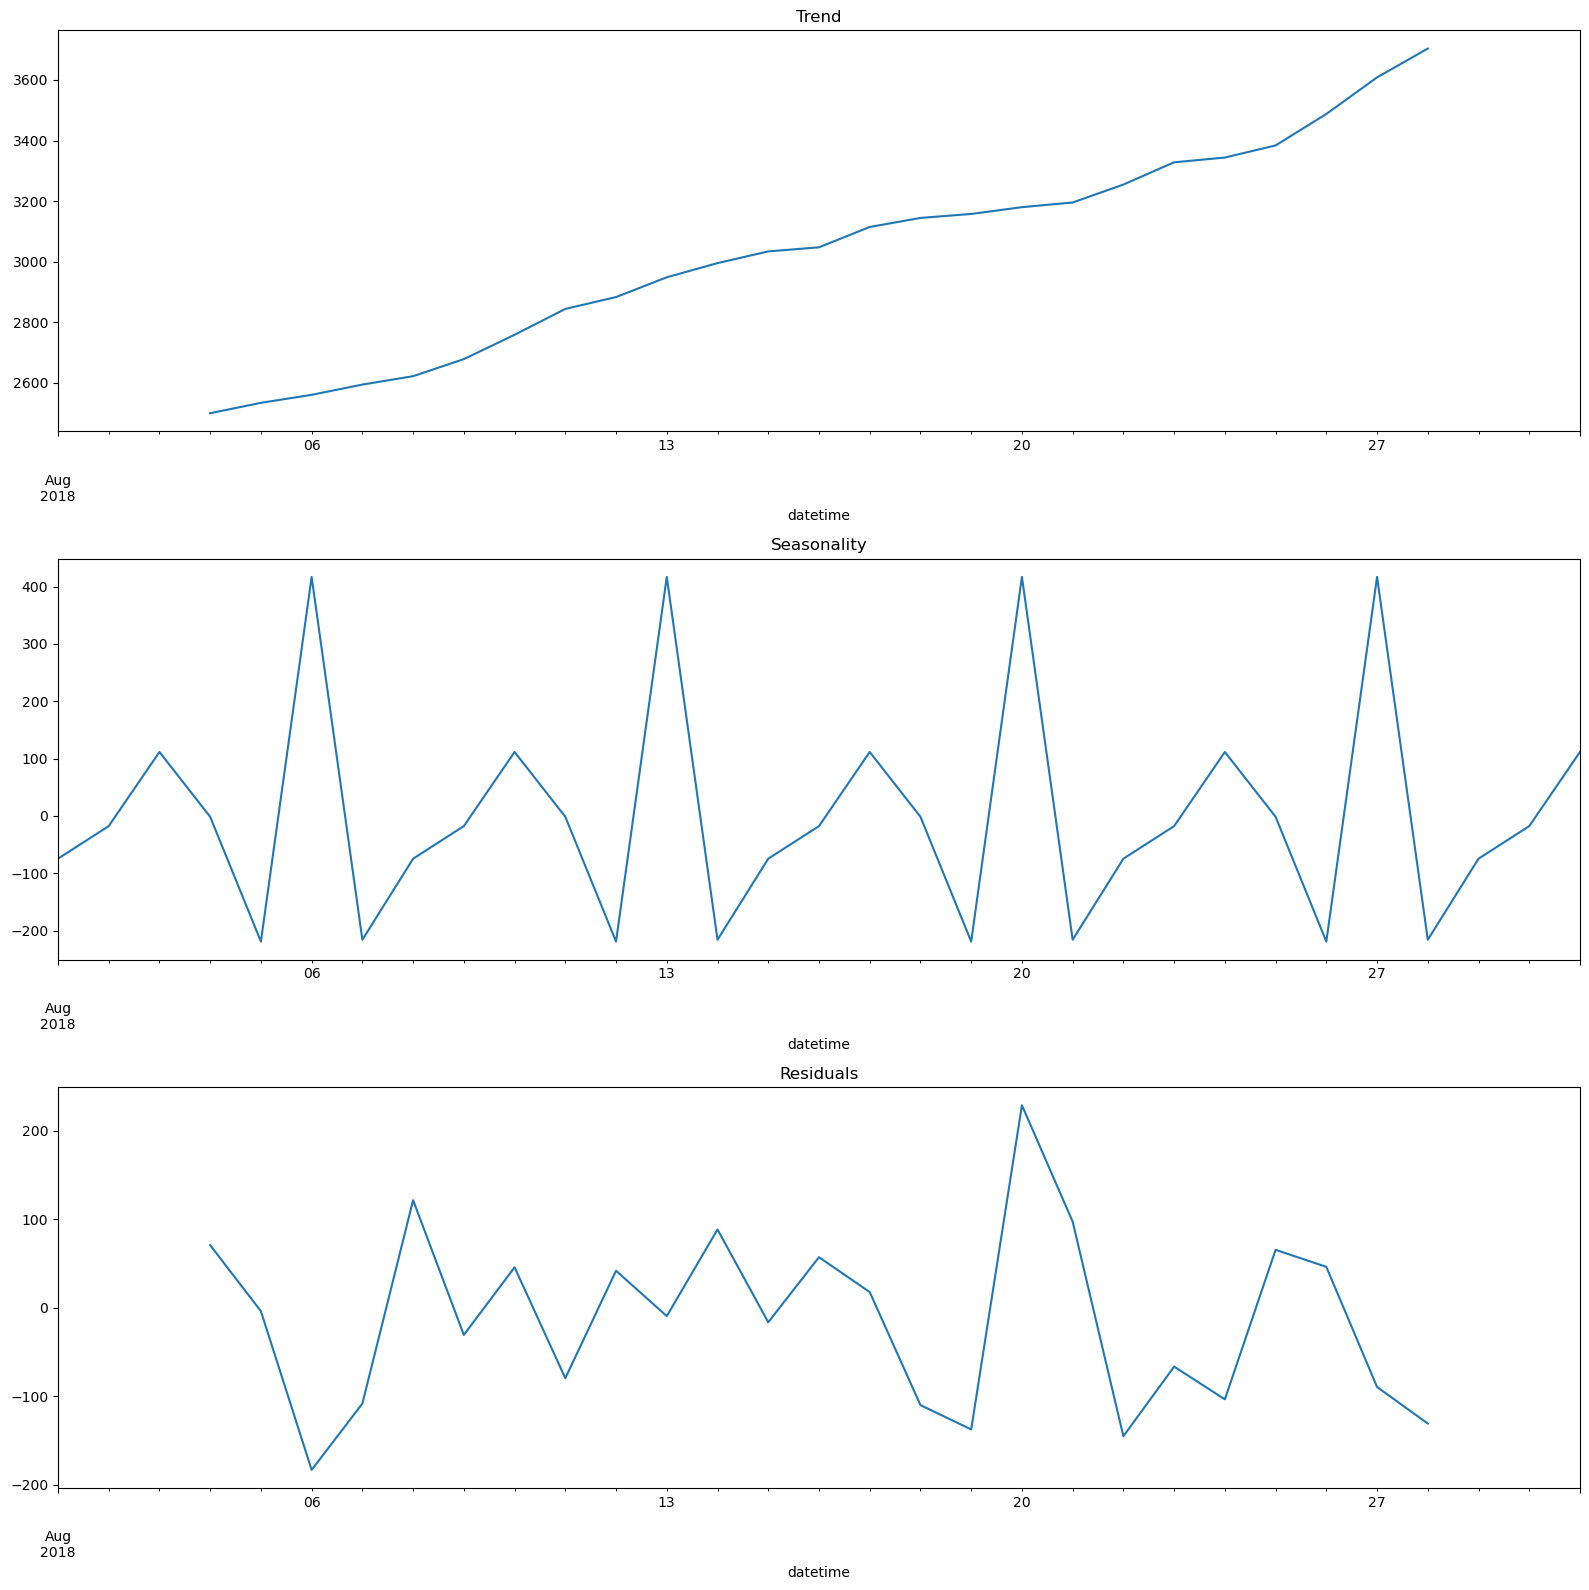

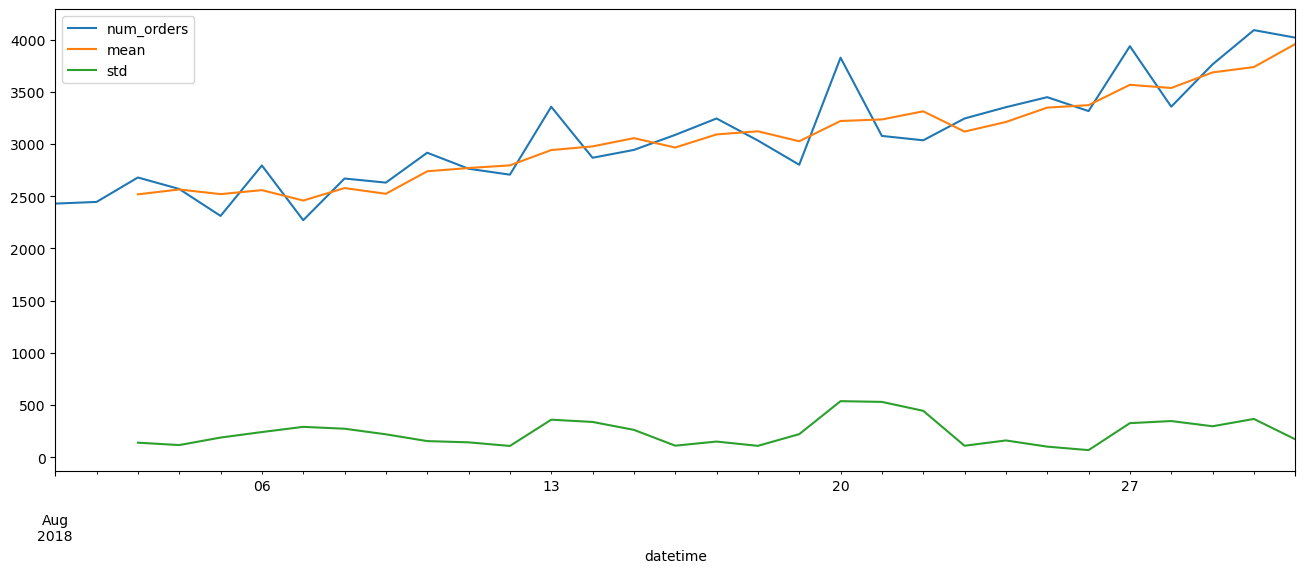

Analysis for first week hourly


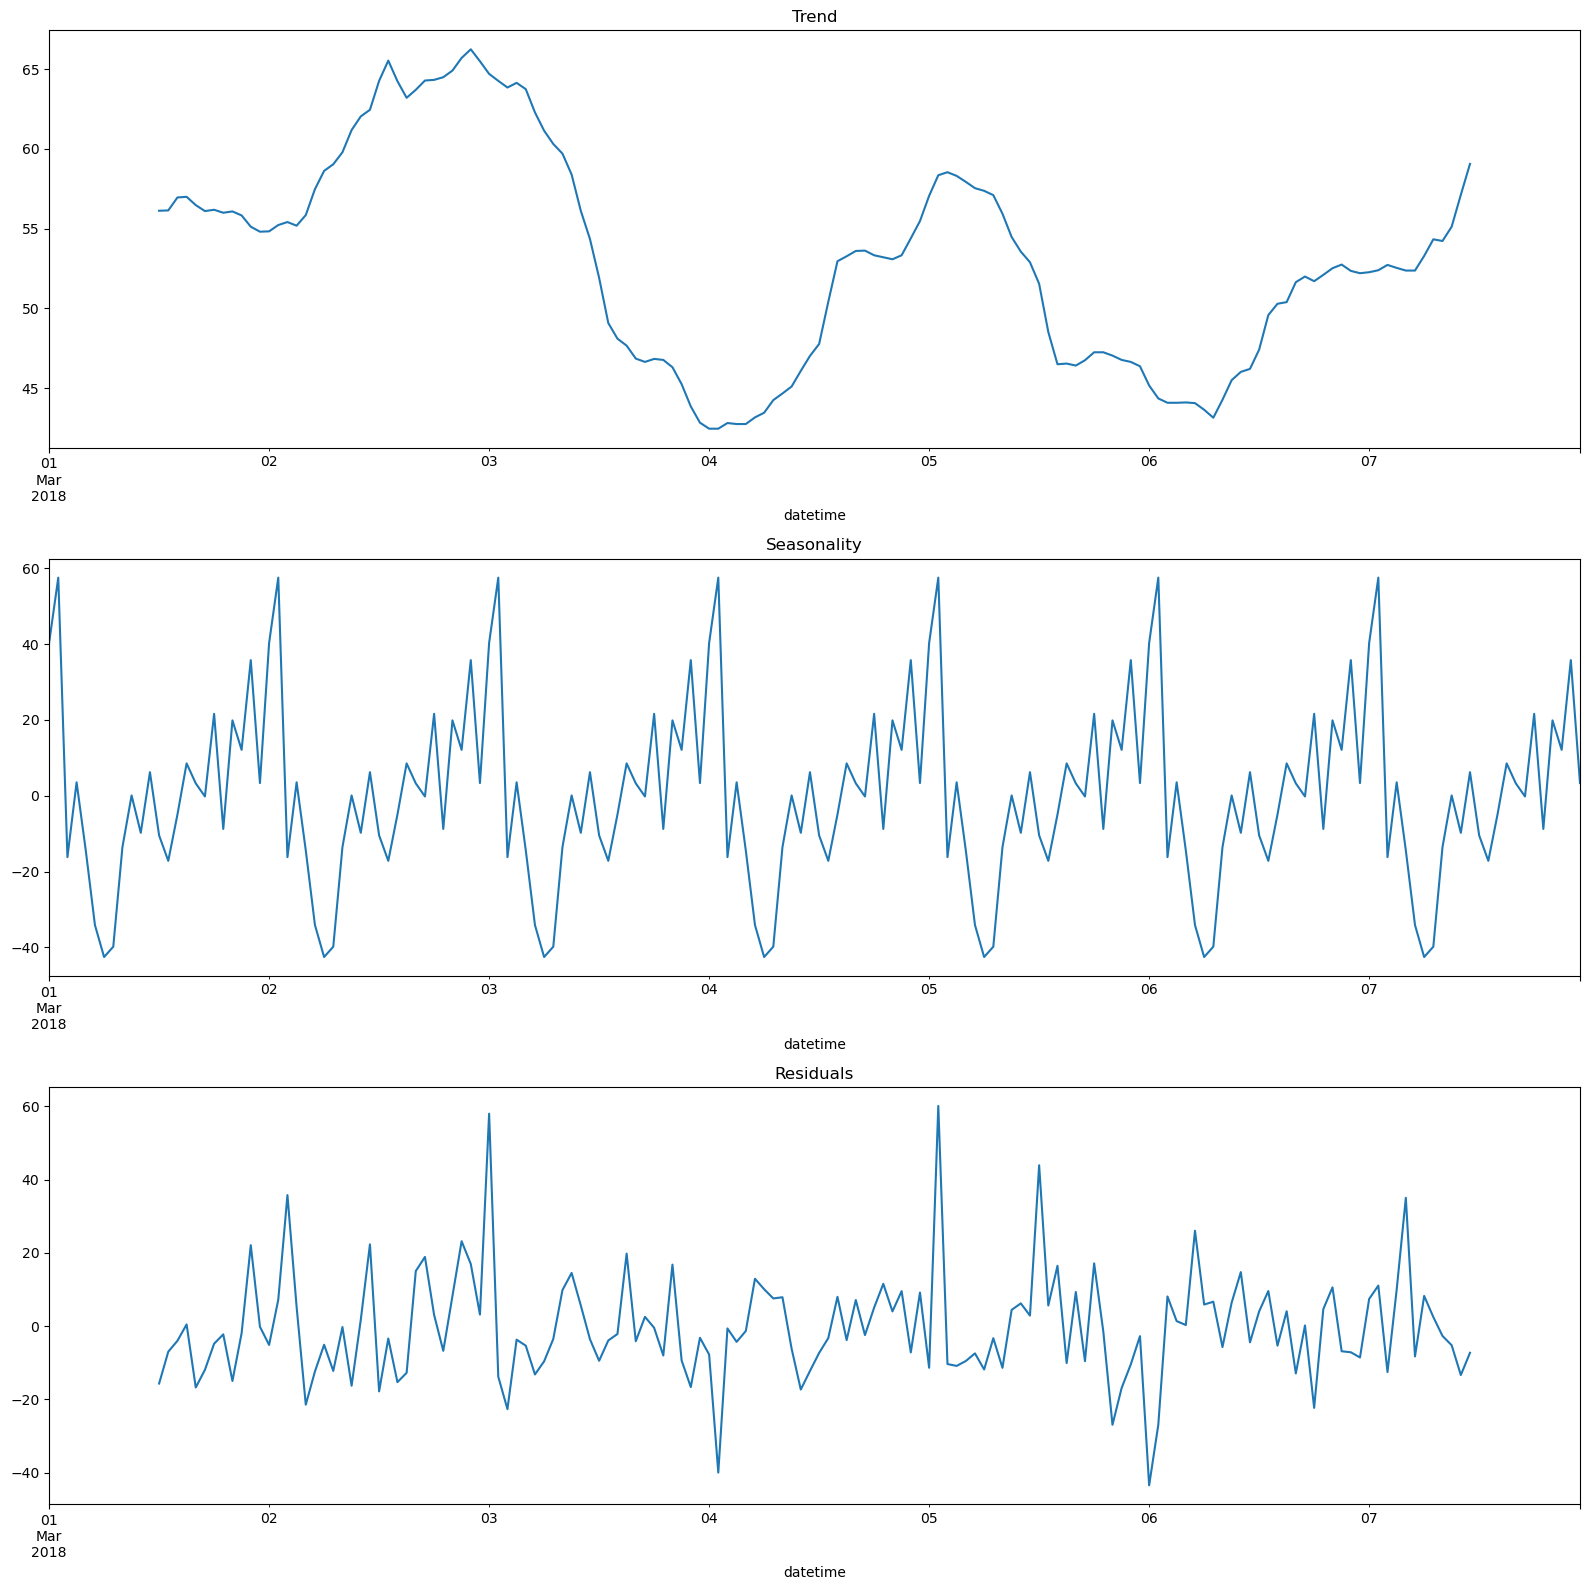

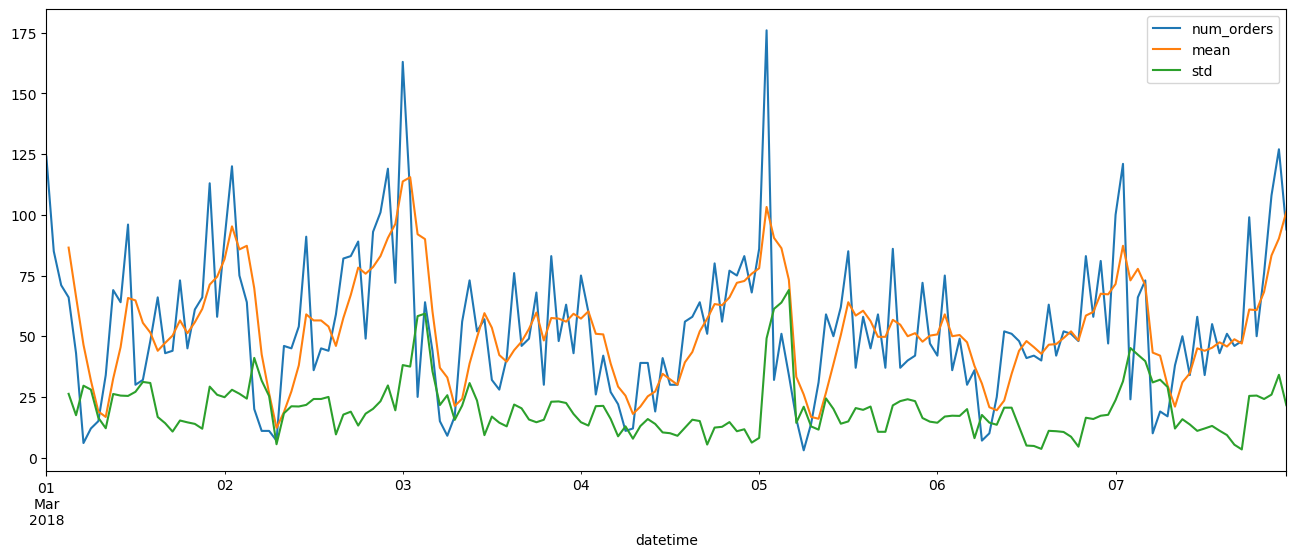

Analysis for last week hourly


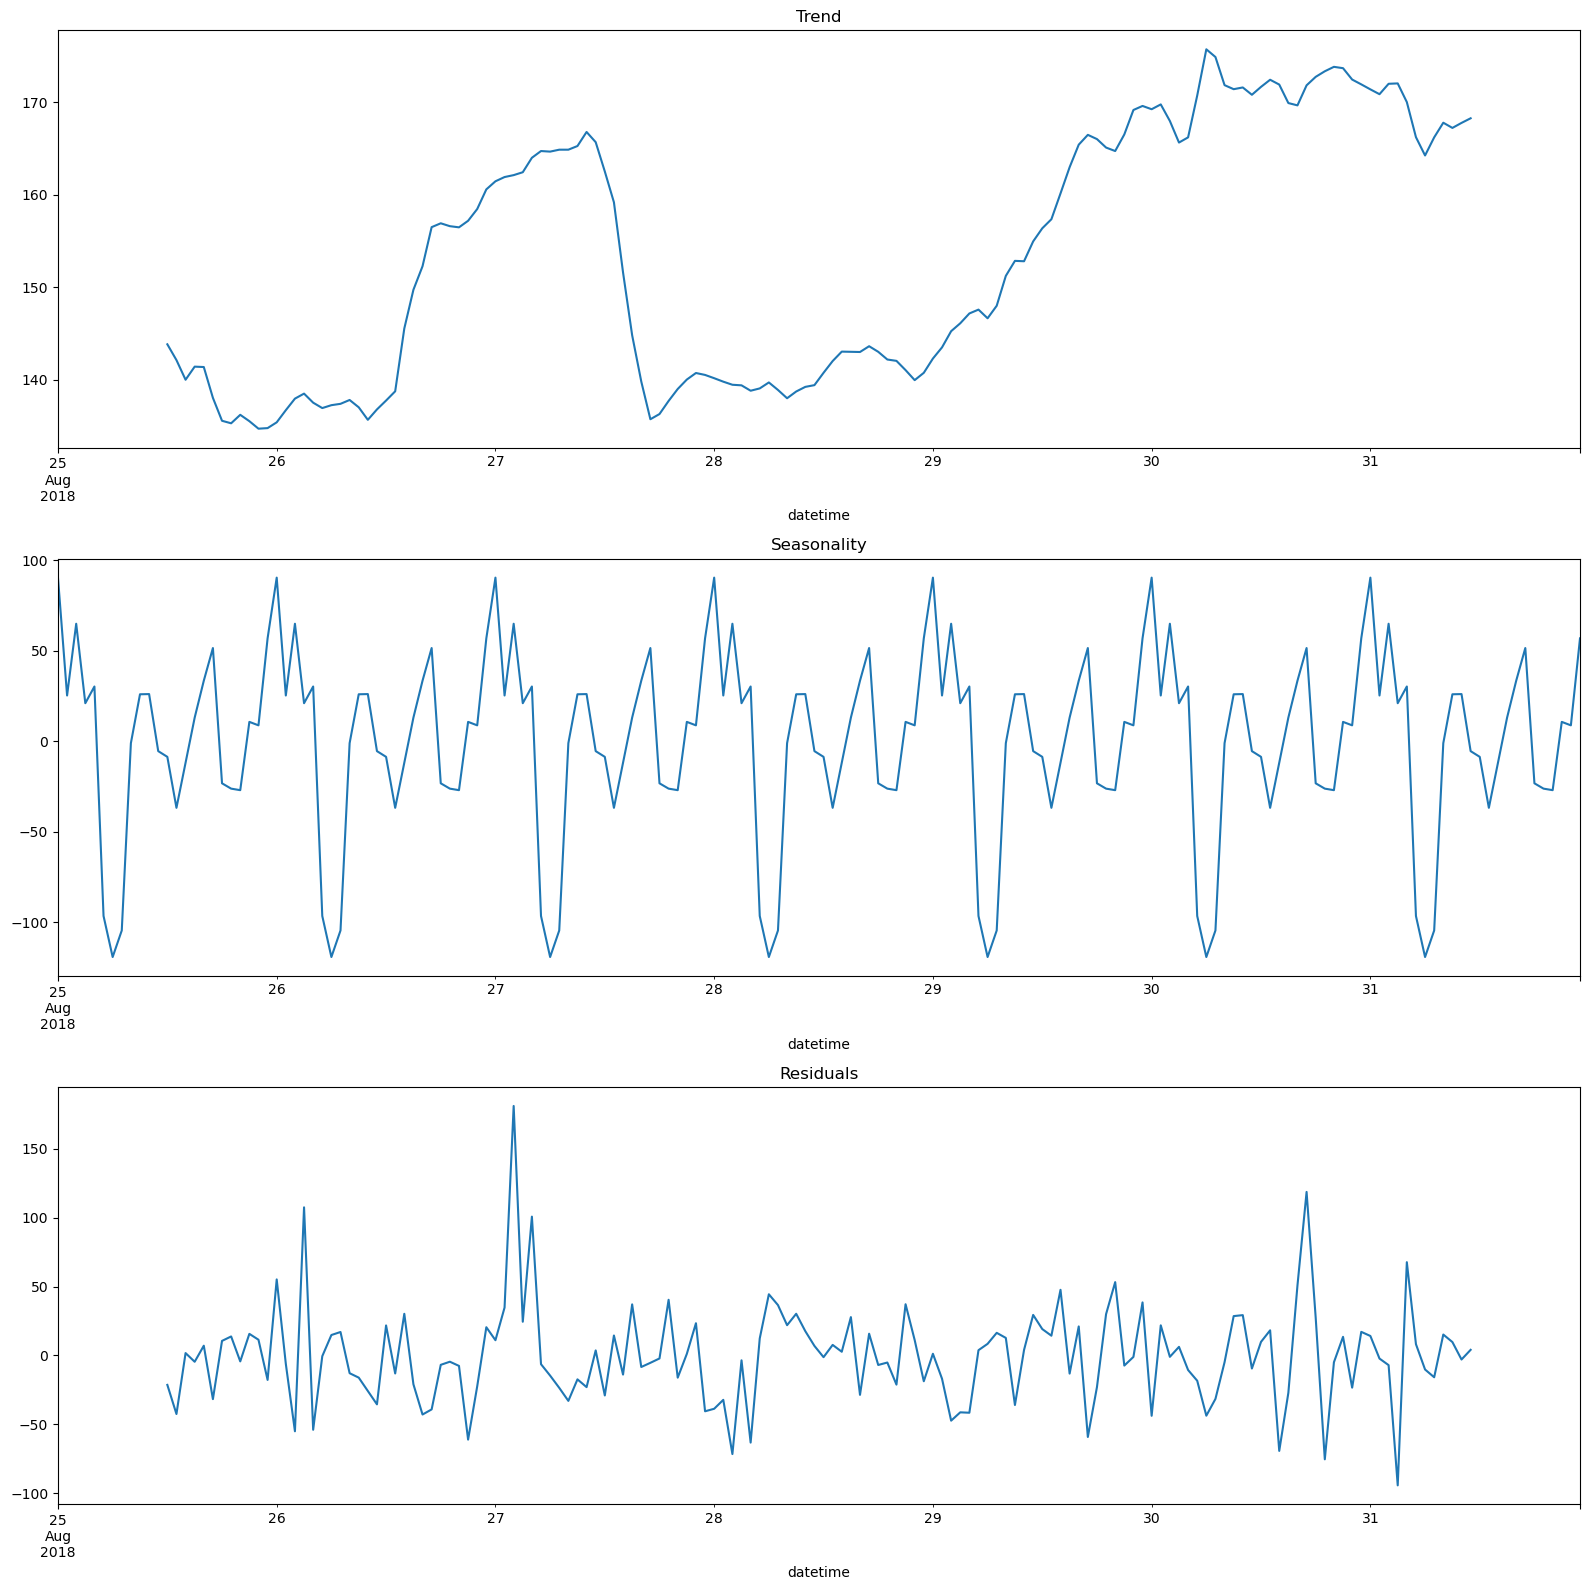

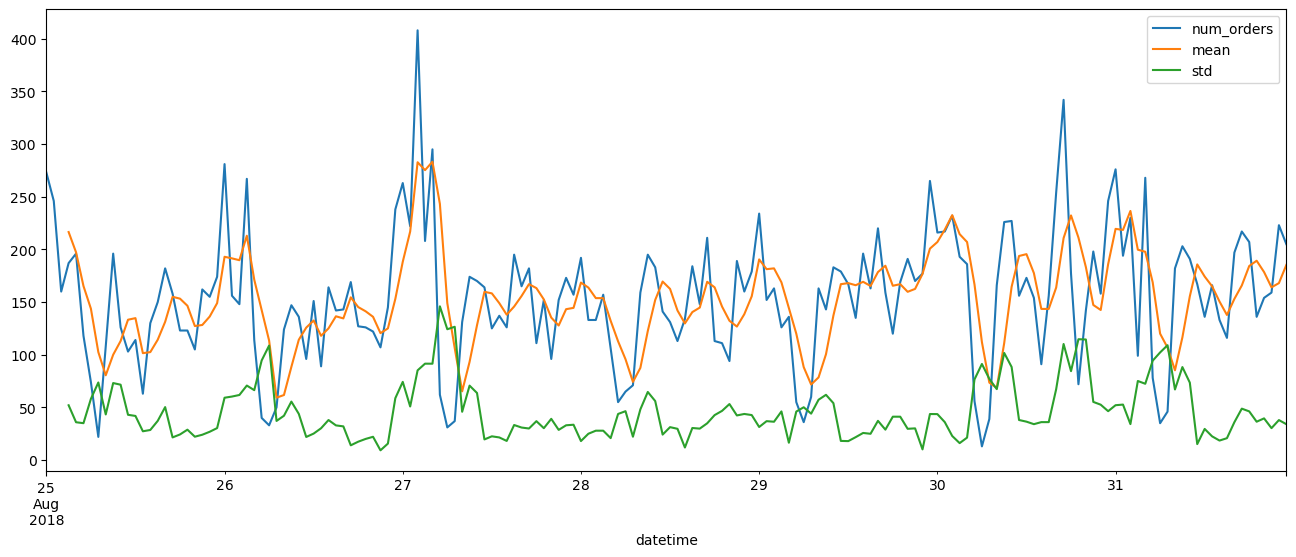

In [7]:
decompose_and_show_info(df_1D, 'august daily', '2018-08', '2018-09', 3)
decompose_and_show_info(df_1H, 'first week hourly', '2018-03-01 00:00:00', '2018-03-07 23:50:00', 4)
decompose_and_show_info(df_1H, 'last week hourly', '2018-08-25 00:00:00', '2018-08-31 23:50:00', 4)

We can see a general trend towards a greater number of evening orders and a drop in night demand. We can also see the dependence on the day of the week. This data should be useful for model training.
Let's check the difference of the time series.

Analysis for august hourly, one day shift


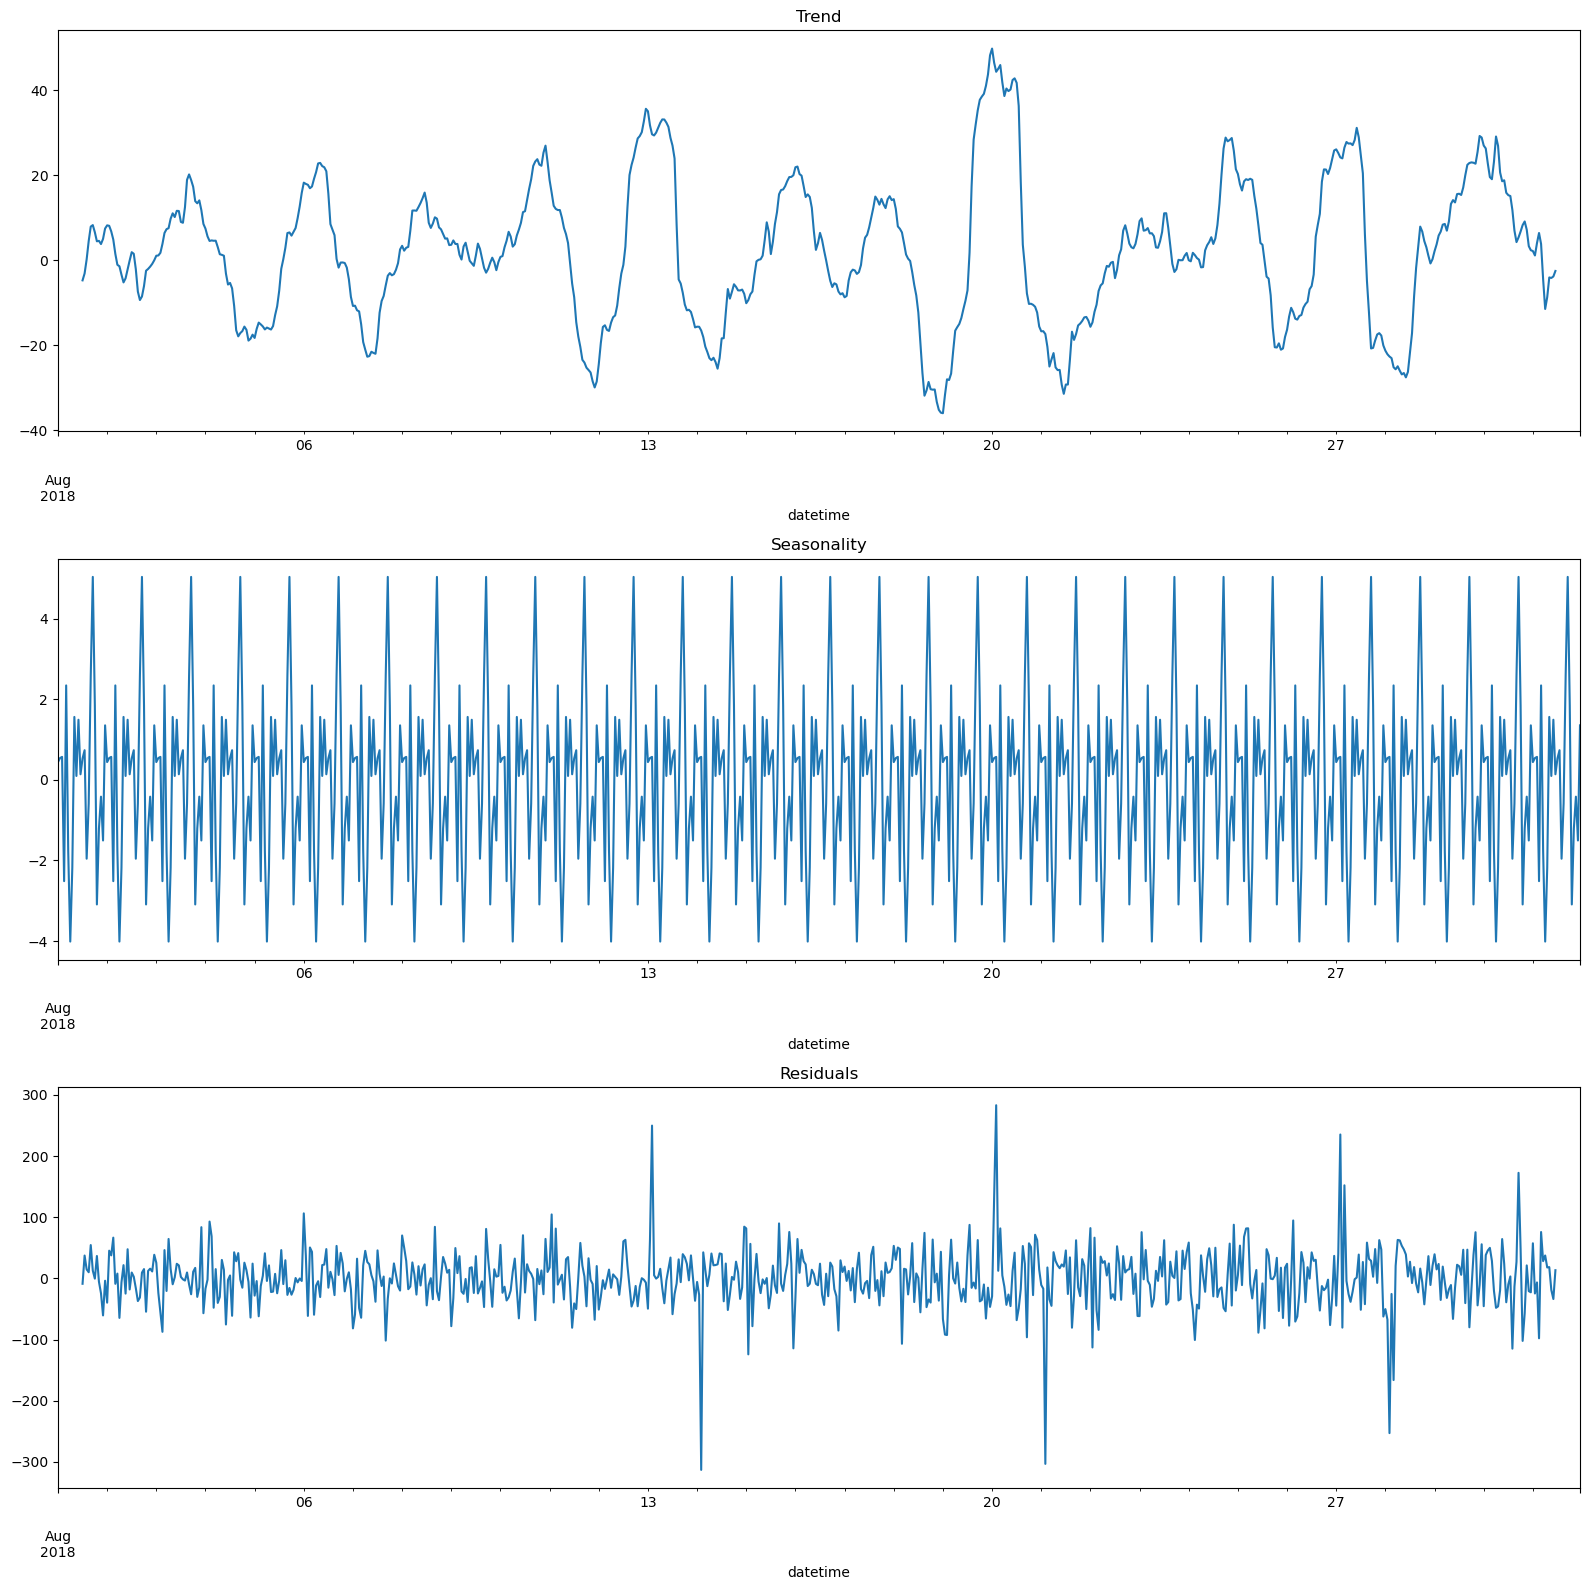

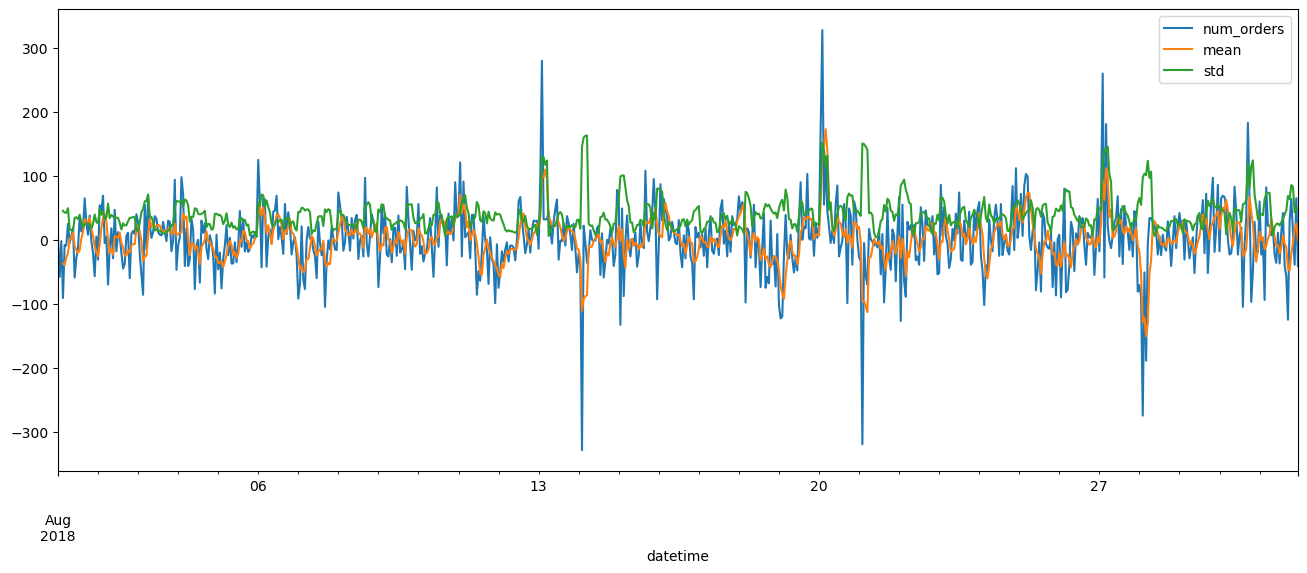

In [8]:
decompose_and_show_info(df_1H - df_1H.shift(24),
                        'august hourly, one day shift', '2018-08-01 00:00:00', '2018-08-31 23:50:00', 4)

When subtracting the previous day's values, the trend goes away, but the weekly seasonality of orders is clearly visible.

Let's consider the autocorrelation of the time series.

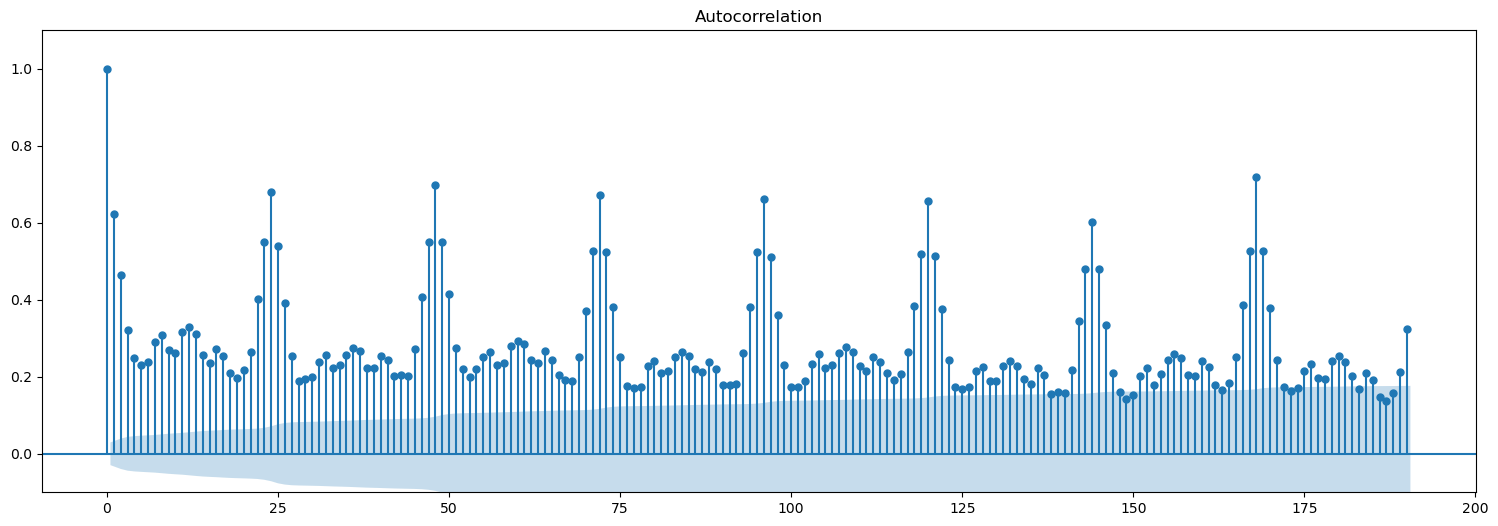

In [9]:
fig = tsaplots.plot_acf(df_1H['num_orders'], lags = 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

### Dickey-Fuller stationarity

In [10]:
adf_test = adfuller(df_1H['num_orders'])
print('p-value = ' + str(adf_test[1]))
pvalue = 0.05

if adf_test[1] <= pvalue:
    print('The series is stationary by the Dickey-Fuller criterion - can be predicted')
else:
    print('The series is NOnnstationary by the Dickey-Fuller criterion - it cannot be predicted')

p-value = 0.02894005140261284
The series is stationary by the Dickey-Fuller criterion - can be predicted


### New parameters and sampling split
Since exploratory analysis of the data showed periodicity depending on time of day, day of week, and week in month, let's make these data additional parameters. Also, remember that the average number can be a good parameter, let's add this feature. We will make the creation of new parameters and preparation of samples a function, so that we can change something in the process of model training.

In [11]:
def make_features_and_split_data(df, max_lag, rolling_mean_size, lag_diamter = -1,
                                 new_features_need = True, rolling_lag_need = True, rolling_mean_need = True):
    """
    The function is used to create a set of parameters and targets, dividing the initial sample into training 
    and test samples.
    Variables:
    new_features_need - inclusion of calendar features 
    rolling_lag_need - inclusion of lagged features
    rolling_mean_need - inclusion of features with rolling mean
    max_lag - maximum lag value (all from 1 up to max_lag will be created)
    rolling_mean_size rolling mean (strictly in the past from the moment)
    lag_diamter - when specified, creates lag variables only around the max_lag value.
    For example, max_lag = 24, lag_diameter = 3,
    will produce the following set of lags: 21, 22, 23, 24, 25, 26, 27
    
    """
    if (new_features_need):
        df['week_of_month'] = df.index.day // 7
        df['dayofweek'] = df.index.dayofweek
        df['hour'] = df.index.hour

    if (rolling_lag_need):
        if (lag_diamter == -1):
            for lag in range(1, max_lag + 1):
                df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        else:
            for lag in range(max_lag - lag_diamter, max_lag + lag_diamter):
                df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
            
    if (rolling_mean_need):
        df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()
        
    df = df.dropna(axis=0, how='any').reset_index(drop=True)
    
    features_train, features_test, targets_train, targets_test = train_test_split(
        df.drop('num_orders', axis=1), df['num_orders'], shuffle=False, test_size=0.1)

    return features_train, features_test, targets_train, targets_test

Let's make several different datasets to train the models.
The analytically chosen parameters contain calendar features, a weekly set of lags, and a small average of the previous 3 values.
However, it would also be interesting to see how different parameter sets affect the model prediction.
For this purpose, let's create a set of parameters with different variations, and train the best model selected on the analytically fitted parameters on them.

In [12]:
analytical_features_train, analytical_features_test,\
    analytical_targets_train, analytical_targets_test =\
        make_features_and_split_data(df_1H, 172, 3, -1, True, True, True)

In [13]:
data_collection = pd.DataFrame({
                    'features_train': [],
                    'features_test': [],
                    'targets_train': [],
                    'targets_test': [],
                    'max_lag': [],
                    'rolling_mean_size': [],
                    'lag_diamter': [],
                    'new_features_need': [],
                    'rolling_lag_need': [],
                    'rolling_mean_need': []
})


def append_data_collection(df, max_lag, rolling_mean_size, lag_diamter,
                                    new_features_need, rolling_lag_need, rolling_mean_need):
    global data_collection
    description = f'''max_lag = {max_lag}, rolling_mean_size = {rolling_mean_size},
                    lag_diamter = {lag_diamter}, new_features_need = {new_features_need},
                    rolling_lag_need = {rolling_lag_need}, rolling_mean_need = {rolling_mean_need}'''
    
    features_train, features_test, targets_train, targets_test = make_features_and_split_data(
                                    df, max_lag, rolling_mean_size, lag_diamter,
                                    new_features_need, rolling_lag_need, rolling_mean_need)
    
    new_row = {'features_train': features_train,
                'features_test': features_test,
                'targets_train': targets_train,
                'targets_test': targets_test,
                'max_lag': max_lag,
                'rolling_mean_size': rolling_mean_size,
                'lag_diamter': lag_diamter,
                'new_features_need': new_features_need,
                'rolling_lag_need': rolling_lag_need,
                'rolling_mean_need': rolling_mean_need
              }

    data_collection = data_collection.append(new_row, ignore_index=True)
    
    return
    
max_lag_list = [12, 24, 168]
rolling_mean_size_list = [3, 6, 12, 24]
lag_diamter_list = [-1, 3]
new_features_need_list = [True, False]
rolling_lag_need_list = [True, False]
rolling_mean_need_list = [True, False]

for new_features_need_value in new_features_need_list:
    for rolling_lag_need_value in rolling_lag_need_list:
        for rolling_mean_need_value in rolling_mean_need_list:
            if (rolling_mean_need_value):
                for rolling_mean_size_value in rolling_mean_size_list:
                    if (rolling_lag_need_value):
                        for max_lag_value in max_lag_list:
                            for lag_diamter_value in lag_diamter_list:
                                append_data_collection(df_1H, max_lag_value, rolling_mean_size_value,
                                                       lag_diamter_value, new_features_need_value,
                                                       rolling_lag_need_value, rolling_mean_need_value)
                    else:
                        max_lag_value = 0
                        lag_diamter_value = 0
                        append_data_collection(df_1H, max_lag_value, rolling_mean_size_value,
                                                       lag_diamter_value, new_features_need_value,
                                                       rolling_lag_need_value, rolling_mean_need_value)
            else:
                rolling_mean_size_value = 0
                if (rolling_lag_need_value):
                        for max_lag_value in max_lag_list:
                            for lag_diamter_value in lag_diamter_list:
                                append_data_collection(df_1H, max_lag_value, rolling_mean_size_value,
                                                       lag_diamter_value, new_features_need_value,
                                                       rolling_lag_need_value, rolling_mean_need_value)
                else:
                    max_lag_value = 0
                    lag_diamter_value = 0
                    append_data_collection(df_1H, max_lag_value, rolling_mean_size_value,
                                                   lag_diamter_value, new_features_need_value,
                                                   rolling_lag_need_value, rolling_mean_need_value)
                
display(data_collection)
display(data_collection.info())
display(data_collection['features_train'][69].T)

,features_train,features_test,targets_train,targets_test,max_lag,rolling_mean_size,lag_diamter,new_features_need,rolling_lag_need,rolling_mean_need
0,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,12.0,3.0,-1.0,1.0,1.0,1.0
1,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,12.0,3.0,3.0,1.0,1.0,1.0
2,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,24.0,3.0,-1.0,1.0,1.0,1.0
3,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,24.0,3.0,3.0,1.0,1.0,1.0
4,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,168.0,3.0,-1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
65,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,0.0,3.0,0.0,0.0,0.0,1.0
66,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,0.0,6.0,0.0,0.0,0.0,1.0
67,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,0.0,12.0,0.0,0.0,0.0,1.0
68,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,0.0,24.0,0.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   features_train     70 non-null     object 
 1   features_test      70 non-null     object 
 2   targets_train      70 non-null     object 
 3   targets_test       70 non-null     object 
 4   max_lag            70 non-null     float64
 5   rolling_mean_size  70 non-null     float64
 6   lag_diamter        70 non-null     float64
 7   new_features_need  70 non-null     float64
 8   rolling_lag_need   70 non-null     float64
 9   rolling_mean_need  70 non-null     float64
dtypes: float64(6), object(4)
memory usage: 5.6+ KB


None

,0,1,2,3,4,5,6,7,8,9,...,3809,3810,3811,3812,3813,3814,3815,3816,3817,3818
week_of_month,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,2.000000,2.000000,2.000000,2.0,2.000000,2.00,2.00
dayofweek,3.000000,3.000000,3.000,3.000000,3.000000,3.000000,3.00,3.000000,3.000000,3.000000,...,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00
hour,4.000000,5.000000,6.000,7.000000,8.000000,9.000000,10.00,11.000000,12.000000,13.000000,...,21.0,22.000000,23.000000,0.000000,1.000000,2.000000,3.0,4.000000,5.00,6.00
lag_1,68.000000,60.000000,6.000,6.000000,19.000000,77.000000,97.00,68.000000,80.000000,48.000000,...,82.0,160.000000,104.000000,134.000000,139.000000,231.000000,108.0,190.000000,139.00,47.00
lag_2,65.000000,68.000000,60.000,6.000000,6.000000,19.000000,77.00,97.000000,68.000000,80.000000,...,91.0,82.000000,160.000000,104.000000,134.000000,139.000000,231.0,108.000000,190.00,139.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lag_169,66.000000,43.000000,6.000,12.000000,15.000000,34.000000,69.00,64.000000,96.000000,30.000000,...,67.0,98.000000,101.000000,119.000000,156.000000,101.000000,125.0,121.000000,108.00,50.00
lag_170,71.000000,66.000000,43.000,6.000000,12.000000,15.000000,34.00,69.000000,64.000000,96.000000,...,104.0,67.000000,98.000000,101.000000,119.000000,156.000000,101.0,125.000000,121.00,108.00
lag_171,85.000000,71.000000,66.000,43.000000,6.000000,12.000000,15.00,34.000000,69.000000,64.000000,...,85.0,104.000000,67.000000,98.000000,101.000000,119.000000,156.0,101.000000,125.00,121.00
lag_172,124.000000,85.000000,71.000,66.000000,43.000000,6.000000,12.00,15.000000,34.000000,69.000000,...,133.0,85.000000,104.000000,67.000000,98.000000,101.000000,119.0,156.000000,101.00,125.00


### Conclusions
The data was examined, no outliers were found. The distribution is lognormal.
Seasonality (from time of day, day of week, and time in month) is observed.
Samples were prepared for training.
Analytically selected parameters will be used for model selection, and then the efficiency of training the best model with different parameters will be tested.

## Model training and testing
### Preparations for training
Let's write common functions that will help us in training.

In [14]:
model_list = pd.DataFrame({
                    'model_name': [],
                    'data_name': [],
                    'rmse': [],
                    'comments': [],
                    'model': [],
                    'learning_time': []
})

def append_model_list(model_name, data_name, rmse, comment, best_model, learning_time):
    global model_list
    new_row = {'model_name': model_name, 'data_name': data_name, 'rmse': rmse,
               'comments': comment, 'model': best_model, 'learning_time': learning_time}
    model_list = model_list.append(new_row, ignore_index=True)
    return

def train_and_predict(which_model, model_name, parameters, features, targets, data_name = 'analytical'):
    start = time.time()
    
    cv = TimeSeriesSplit(n_splits=9)
    model = GridSearchCV(which_model, param_grid=parameters,
                             scoring='neg_root_mean_squared_error', cv=cv)
    model.fit(features, targets)
    cv_results = cross_val_score(model, features, targets, cv=cv, scoring='neg_root_mean_squared_error')
    
    print(f'rmse = {-cv_results.mean():.2f} +- {cv_results.std():.2f}')
    print(model.best_params_)
    
    end = time.time()
    learning_time = end-start
    print('Learning time:', learning_time)
    comment = model.best_params_
    append_model_list(model_name, data_name,-cv_results.mean(), comment, model, learning_time)

    return

### Dummy models
At first, it is important to consider prediction by mean and previous value.

In [15]:
# Aproximation by mean
start = time.time()
predictions_median = np.ones(analytical_targets_test.shape) * analytical_targets_train.median()
rmse_median = mean_squared_error(analytical_targets_test, predictions_median, squared=False)
end = time.time()
learning_time = end-start
print('rmse for mean:', rmse_median)

append_model_list('aproximation by mean', 'analytical', rmse_median, '', '', learning_time)

rmse for mean: 87.03915278566916


The predictions are not so bad.
Apparently, due to the crowding of data around the mean, outliers have relatively little effect on the error value.

In [16]:
# Aproximation by previous
start = time.time()
prediction_previous = analytical_targets_test.shift()
prediction_previous.iloc[0] = analytical_targets_train.iloc[-1]
rmse_previous = mean_squared_error(analytical_targets_test, prediction_previous, squared=False)
end = time.time()
learning_time = end-start
print("rmse for previous:", rmse_previous)

append_model_list('approximatio nby previous', 'analytical', rmse_previous, '', '', learning_time)

rmse for previous: 58.819724582830204


The value has become better! In principle, this is logical, there are no sharp jumps in the initial data.

### Linear regression

In [17]:
params_lin_reg = {}

train_and_predict(LinearRegression(), 'LinearRegression',
                  params_lin_reg, analytical_features_train, analytical_targets_train)


rmse = 22.80 +- 2.69
{}
Learning time: 2.0523014068603516


Linear regression worked well on the training sample.
Let's see how more complex models will cope with it.

### Decision tree

In [18]:
%%time

params_tree = {'max_depth':[2, 4, 6, 10, 20]}

train_and_predict(DecisionTreeRegressor(random_state = 42), 'DecisionTreeRegressor',
                  params_tree, analytical_features_train, analytical_targets_train)

rmse = 25.72 +- 3.91
{'max_depth': 4}
Learning time: 35.385762453079224
CPU times: total: 36.2 s
Wall time: 35.4 s


The decision tree performed quite well, but worse than linear regression.

### Random Forest

In [19]:
%%time

params_forest = {'max_depth':[2, 6],
                 'max_features':[4, 12]}

train_and_predict(RandomForestRegressor(random_state = 42), 'RandomForestRegressor',
                  params_forest, analytical_features_train, analytical_targets_train)


rmse = 24.50 +- 4.77
{'max_depth': 6, 'max_features': 12}
Learning time: 135.97429943084717
CPU times: total: 2min 13s
Wall time: 2min 15s


Random forest has already produced results better than decision tree, but still worse than linear regression.

### Model Comparison

In [20]:
display(model_list.sort_values('rmse'))

,model_name,data_name,rmse,comments,model,learning_time
2,LinearRegression,analytical,22.799113,{},"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",2.052301
4,RandomForestRegressor,analytical,24.502598,"{'max_depth': 6, 'max_features': 12}","GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",135.974299
3,DecisionTreeRegressor,analytical,25.719602,{'max_depth': 4},"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...",35.385762
1,approximatio nby previous,analytical,58.819725,,,0.004843
0,aproximation by mean,analytical,87.039153,,,0.001053


In [21]:
def visualization_models(name, models_indexes, xticks_list):
    sns.barplot(x = models_indexes, y = model_list['rmse'][models_indexes])
    plt.title(f'rmse for {name}')
    plt.ylabel('rmse')
    plt.xticks(ticks=[0, 1, 2], labels=xticks_list, rotation=45)
    plt.show()
    
    sns.barplot(x = models_indexes, y = model_list['learning_time'][models_indexes])
    plt.title(f'learning time for {name}')
    plt.ylabel('learning time')
    plt.xticks(ticks=[0, 1, 2], labels=xticks_list, rotation=45)
    plt.show()
    
    return

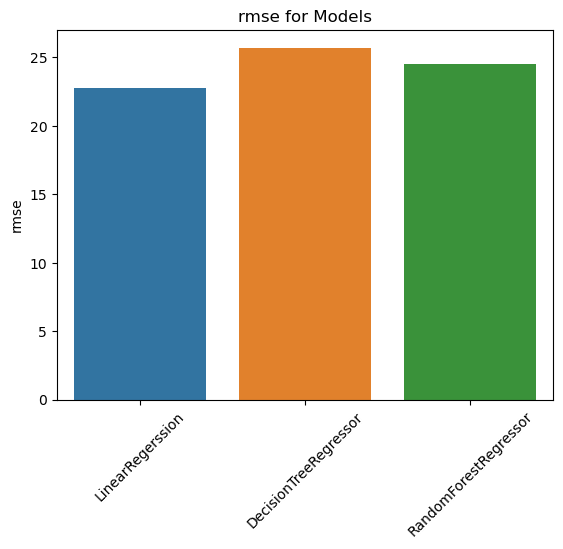

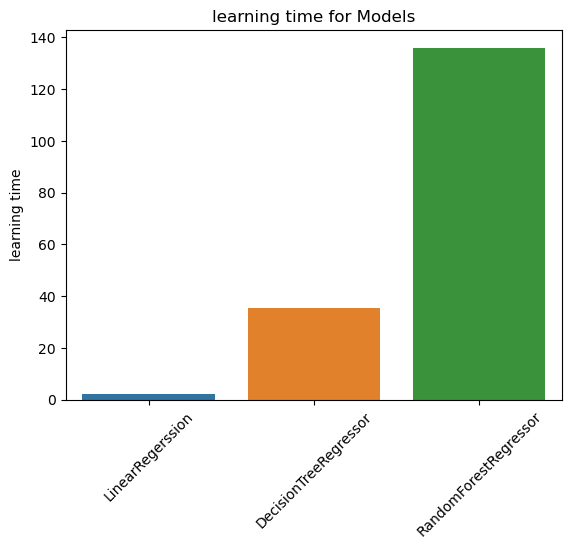

In [22]:
visualization_models('Models', [2, 4, 3],
                     ['LinearRegerssion', 'DecisionTreeRegressor', 'RandomForestRegressor'])

**Linear regression** performed best.

### Verification on a test sample

In [23]:
predictions_on_test = model_list['model'][2].predict(analytical_features_test)
rmse_on_test = mean_squared_error(analytical_targets_test, predictions_on_test, squared=False)
print('rmse for test sample:', rmse_on_test)

rmse for test sample: 34.41949442069096


Worse than during training, but still good.

### Checking the influence of parameters
For this purpose, we will train the linear regression using a simplified algorithm.

In [24]:
%%time
def new_linear_regression(features_train, target_train):
    cv = TimeSeriesSplit(n_splits=3).split(features_train)
    model = LinearRegression()
    score = cross_val_score(model, features_train, target_train,
                            scoring='neg_root_mean_squared_error', cv=cv)
    rmse = round(np.mean(-score), 2)
    return rmse

data_collection = data_collection.assign(rmse = data_collection.shape[0] * [0])

for i in range(len(data_collection)):
    data_collection.loc[i, 'rmse'] = new_linear_regression(
                                                        data_collection.loc[i, 'features_train'],
                                                        data_collection.loc[i, 'targets_train']
                                                        )


CPU times: total: 52.6 s
Wall time: 7.39 s


count    70.000000
mean     23.610000
std       0.279637
min      23.380000
25%      23.380000
50%      23.390000
75%      23.950000
max      23.950000
Name: rmse, dtype: float64

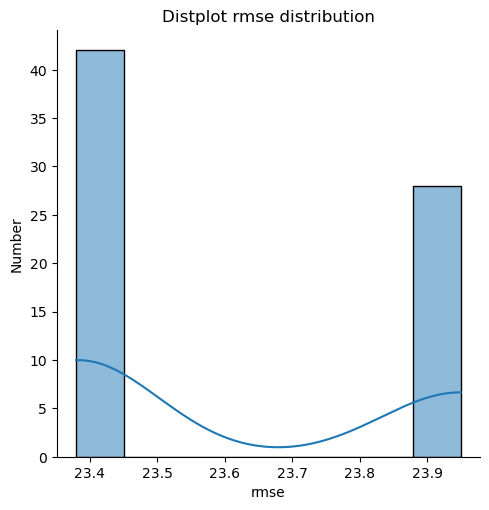

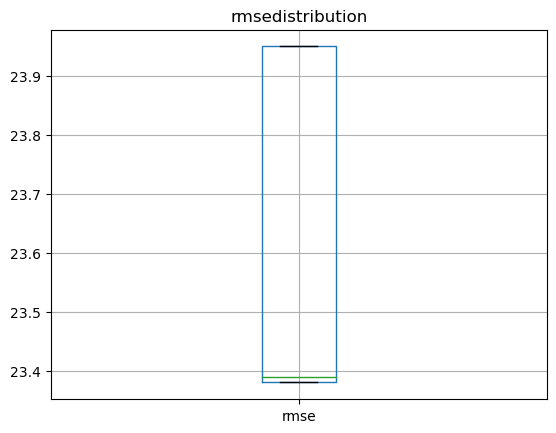

,features_train,features_test,targets_train,targets_test,max_lag,rolling_mean_size,lag_diamter,new_features_need,rolling_lag_need,rolling_mean_need,rmse
69,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,0.0,0.0,0.0,0.0,0.0,0.0,23.95
53,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,12.0,24.0,-1.0,0.0,1.0,1.0,23.95
33,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,0.0,24.0,0.0,1.0,0.0,1.0,23.95
29,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,168.0,0.0,3.0,1.0,1.0,0.0,23.95
28,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,168.0,0.0,-1.0,1.0,1.0,0.0,23.95
...,...,...,...,...,...,...,...,...,...,...,...
42,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,12.0,6.0,3.0,0.0,1.0,1.0,23.38
41,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,12.0,6.0,-1.0,0.0,1.0,1.0,23.38
16,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,168.0,12.0,-1.0,1.0,1.0,1.0,23.38
17,week_of_month dayofweek hour lag_1 l...,week_of_month dayofweek hour lag_1 l...,0 60 1 6 2 6 3 1...,3819 54 3820 91 3821 135 3822 15...,168.0,12.0,3.0,1.0,1.0,1.0,23.38


In [25]:
analysis_of_quntitative_parametr(data_collection, 'rmse')
display(data_collection.sort_values('rmse', ascending=False))

In general, the parameters had very little impact on prediction quality.

## Conclusions
The data was examined for quality, the quality was found to be good.
Temporal patterns were identified - fluctuations in the number of orders from time of day, day of week and part of month.
Models were trained with selection of hyperparameters and features: dummy models, linear regression, decision tree, random forest.
The best results were shown by the linear regression model rmse = 34.4, with the required level not exceeding 48.